# Redes Neuronales: Práctico 3

## Ejercicio A

Implementá una red feed-forward auto-encoder con una capa oculta para aprender la función identidad
con la base de datos MNIST de dígitos escritos a mano y digitalizados. La red debe tener 784 unidades de
entrada (pues los dígitos tienen 28 por 28 píxeles), una capa oculta de 64 neuronas y una capa de salida
de 784 neuronas. Usá la función de error cuadrático medio para el descenso por el gradiente estocástico
(SGD), implementá dropout con p = 0.1 y minibatch de tamaño 1000. Recordá que la base MNIST tiene
60000 imágenes en el conjunto de entrenamiento y 10000 imágenes en el conjunto de test.
Graficá el Error en función de las épocas y la función tanto para el aprendizaje como para el
testeo. 

Presentá los gráficos que creas necesarios para convencerme de que anda bien.

Para completar el práctico vamos a utilizar el dataset de MNIST que ya viene cargado en Keras.

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import TensorBoard

import numpy as np
# Debemos cargar los conjuntos de train y de test de acuerdo a la documentación.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [21]:
# Dimension de la hidden layer
encoder_dim = 64
autoenc = Sequential()

# Vamos a recibir un objeto con 784 elementos (28x28 pixeles), con cuidado de agregar una dimensión vacía
# Debe ser del tipo Dropout
autoenc.add(layers.Dropout(0.1, input_shape=(784,)))

# Usamos RELU como función de activación para este caso.
autoenc.add(layers.Dense(encoder_dim, activation="relu"))
# Capa de "decodificacion", recibe 784, usamos activación sigmoide.
autoenc.add(layers.Dense(784, activation="sigmoid"))

In [22]:
# Compilamos todo junto, eligiendo nuestro optimizador y la función de pérdida
sgd = SGD(nesterov=True, momentum=0.5, learning_rate=1.0)
autoenc.compile(optimizer=sgd, loss="mean_squared_error")

In [23]:
# Preprocesamos los datos

# Tenemos que normalizar para lograr mejores resultados, vamos a llevar todo desde los valores [0,255] a [0, 1]
x_train = x_train.astype("float32") / np.amax(x_train) 
x_test = x_test.astype("float32") / np.amax(x_test)
print(f"Forma de los datos al empezar: x_train = {x_train.shape}, x_test = {x_test.shape}")

# Tenemos que hacer nuestro input chato, las imágenes de MNIST vienen como matrices 28x28
x_train = x_train.reshape((x_train.shape[0], np.prod(x_train.shape[1:])))
x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))
print(f"Forma de los datos al terminar: x_train = {x_train.shape}, x_test = {x_test.shape}")


Forma de los datos al empezar: x_train = (60000, 784), x_test = (10000, 784)
Forma de los datos al terminar: x_train = (60000, 784), x_test = (10000, 784)


In [24]:
# Entrenamos el autoencoder,
history = autoenc.fit(
    x_train, x_train,
    epochs=200,
    verbose=0,
    shuffle=True,
    batch_size=1000,
#    validation_data=(x_test, x_test),
)

In [25]:
# Vamos a chequear con algunas imágenes si esto funciona
import matplotlib.pyplot as plt
predicted = autoenc.predict(x_test)
def plot_n_random_digits(n=10):
    plt.figure(figsize=(20, 4))
    for idx in range(n):
        ax = plt.subplot(2, n, idx + 1)
        random_idx = np.random.randint(0, x_test.shape[0]-1)
        plt.imshow(x_test[random_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, idx + 1 + n)
        plt.imshow(predicted[random_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

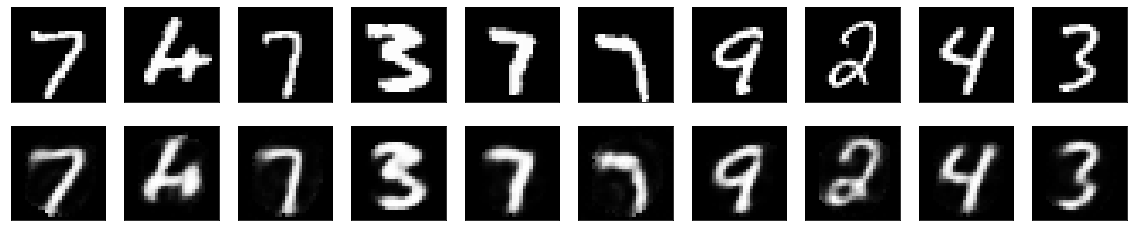

In [26]:
plot_n_random_digits()

Text(0.5, 1.0, 'Función de pérdida (Error cuadrático medio)')

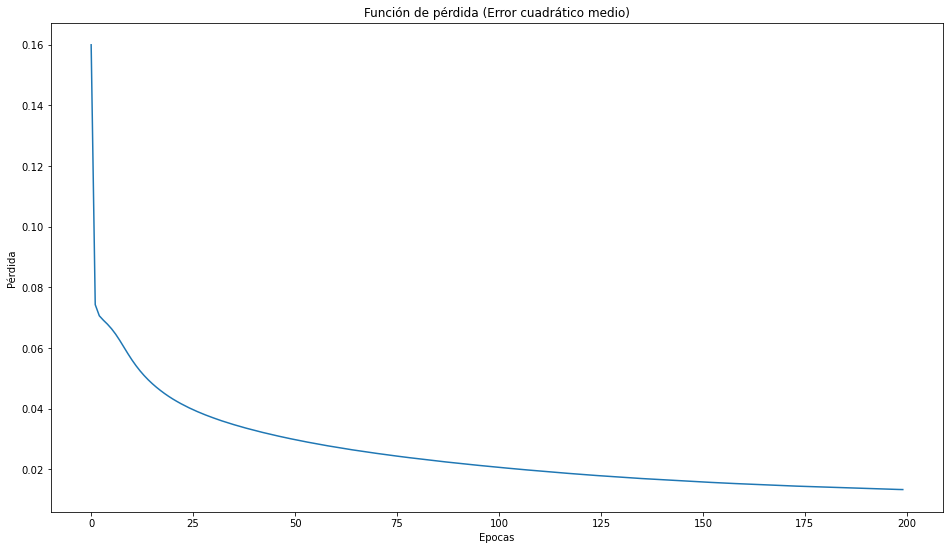

In [27]:
plt.figure(figsize=(16,9))
plt.plot(history.history["loss"])
plt.xlabel("Epocas")
plt.ylabel("Pérdida")
plt.title("Función de pérdida (Error cuadrático medio)")

In [49]:
import time
class Autoencoder:
    model = Sequential()
    def __init__(self, enc_dim=64, dropout=0.1, act_first="relu", act_second="sigmoid"):
        """ Initialize model."""
        self.enc_dim = enc_dim
        self.model.add(layers.Dropout(dropout, input_shape=(784,)))
        # Usamos RELU como función de activación para este caso.
        self.model.add(layers.Dense(enc_dim, activation=act_first))
        # Capa de "decodificacion", recibe 784, usamos activación sigmoide.
        self.model.add(layers.Dense(784, activation=act_second))

    def prepare_data(self):
        """Get data from MNIST and normalize."""
        (x_train, _), (x_test, _) = mnist.load_data()
        # Tenemos que normalizar para lograr mejores resultados, vamos a llevar todo desde los valores [0,255] a [0, 1]
        x_train = x_train.astype("float32") / np.amax(x_train) 
        x_test = x_test.astype("float32") / np.amax(x_test)

        # Tenemos que hacer nuestro input chato, las imágenes de MNIST vienen como matrices 28x28
        self.x_train = x_train.reshape((x_train.shape[0], np.prod(x_train.shape[1:])))
        self.x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))

    def train_model(self, learning_rate=1.0, momentum=0.5, nesterov=True, epochs=100, validate=True):
        sgd = SGD(nesterov=nesterov, momentum=momentum, learning_rate=learning_rate)
        self.model.compile(optimizer=sgd, loss="mean_squared_error")
        val_data = None
        if validate:
            val_data = (self.x_test, self.x_test)
        
        start = time.time()
        self.history = self.model.fit(
            self.x_train, self.x_train,
            epochs=epochs,
            verbose=0,
            shuffle=True,
            batch_size=1000,
            validation_data=val_data,
        )
        end = time.time()
        print(f"Entrenamiento {self.enc_dim} Neuronas: {end - start} segundos.")


Entrenamiento 64 Neuronas: 5.668614387512207 segundos.
Entrenamiento 128 Neuronas: 8.619067668914795 segundos.
Entrenamiento 256 Neuronas: 15.30183458328247 segundos.
Entrenamiento 512 Neuronas: 26.942294597625732 segundos.


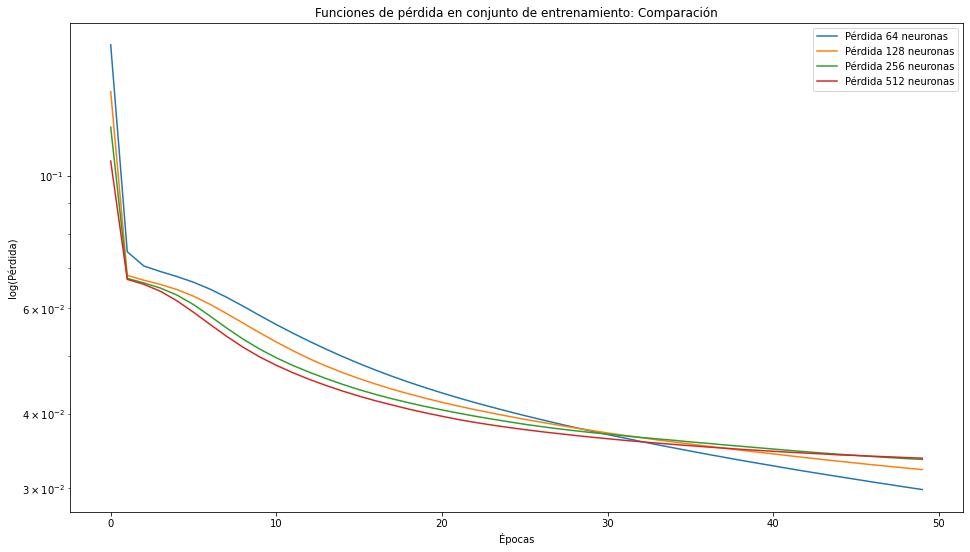

In [50]:
plt.figure(figsize=(16,9))
for dim in [64, 128, 256, 512]:
    autoenc = Autoencoder(enc_dim=dim)
    autoenc.prepare_data()
    autoenc.train_model(epochs=50, validate=False)
    
    plt.semilogy(autoenc.history.history["loss"], label=f"Pérdida {dim} neuronas")
    
plt.title("Funciones de pérdida en conjunto de entrenamiento: Comparación")
plt.xlabel("Épocas")
plt.ylabel("log(Pérdida)")
plt.legend()
plt.savefig("train_loss.png")

Entrenamiento 64 Neuronas: 32.117762327194214 segundos.
Entrenamiento 128 Neuronas: 36.20589780807495 segundos.
Entrenamiento 256 Neuronas: 43.275317907333374 segundos.
Entrenamiento 512 Neuronas: 56.24358010292053 segundos.


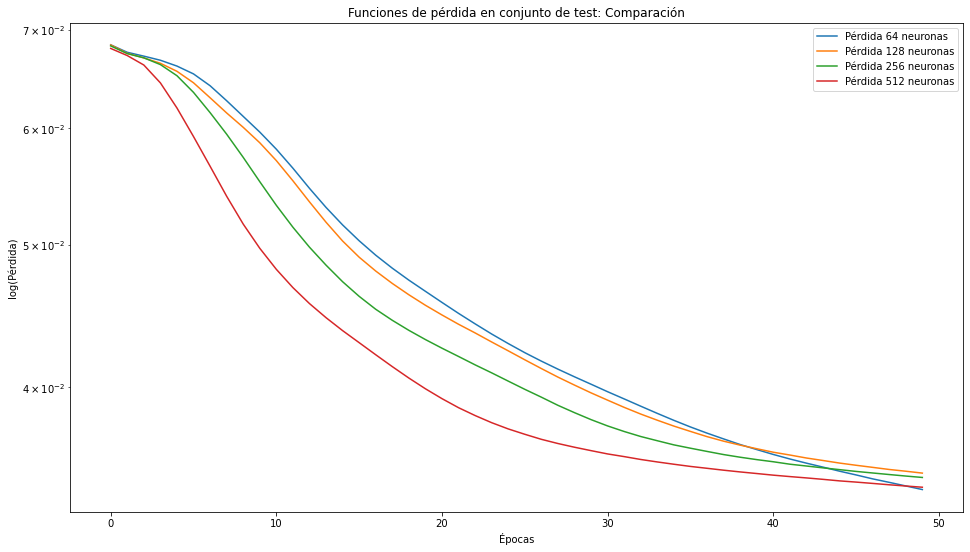

In [51]:
plt.figure(figsize=(16,9))
for dim in [64, 128, 256, 512]:
    autoenc = Autoencoder(enc_dim=dim)
    autoenc.prepare_data()
    autoenc.train_model(epochs=50, validate=True)
    
    plt.semilogy(autoenc.history.history["val_loss"], label=f"Pérdida {dim} neuronas")
    
plt.title("Funciones de pérdida en conjunto de test: Comparación")
plt.xlabel("Épocas")
plt.ylabel("log(Pérdida)")
plt.legend()
plt.savefig("test_loss.png")